## 5. Validación Modelado de Agente Vigilante

In [37]:
# library
import pandas as pd
import tiktoken


import redis as RedisClient

from langchain_openai import OpenAIEmbeddings
from langchain_community.vectorstores.redis.base import Redis as RedisVectorStore

from langchain.chat_models import ChatOpenAI
from langchain.prompts import PromptTemplate
from langchain.chains import LLMChain

from langchain_text_splitters import RecursiveCharacterTextSplitter
from langchain_core.documents import Document

from tqdm import tqdm
import time

In [ ]:

# -------------------------------
# CONSTANTS
# -------------------------------
REDIS_HOST = "localhost"
REDIS_PORT = 6379
REDIS_DB = 0
REDIS_USERNAME = "default"
REDIS_PASSWORD = ""
REDIS_INDEX = "normativas_sii"
GPT_KEY = "sk-proj-..."  # ← Reemplázalo por tu clave real
REDIS_URL = f"redis://{REDIS_USERNAME}:{REDIS_PASSWORD}@{REDIS_HOST}:{REDIS_PORT}/{REDIS_DB}"
MODEL_NAME = "text-embedding-3-large"  # Modelo de OpenAI para embeddings
MODEL_GPT = "gpt-4o"  # Modelo de OpenAI para LLM


import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap

CUSTOM_PALETTE = [
    "#677023", "#F3A7CC", "#5B6E86", "#FF5C73", "#B2A2D6",
    "#DBFF00", "#FFB300", "#212121", "#FEF9ED", "#B4FF00",
    "#F9DA00", "#DAB9CE", "#FFEDD6", "#3D8B84", "#D1B660"
]

cmap_custom = ListedColormap(CUSTOM_PALETTE[0])
# -------------------------------
DATA_DIR ="../raw_data"
CSV_PATH = "classified_regulations.csv"
# Tokenizador para OpenAI embeddings
tokenizer = tiktoken.encoding_for_model(MODEL_NAME)
MAX_TOKENS = 30000
SAFE_TOKENS = 25000  # margen de seguridad

INDEX_NAME = REDIS_INDEX
K = 5  # Número de documentos similares desde Redis
INPUT_FILE = f"{DATA_DIR}/{CSV_PATH}"
OUTPUT_FILE = f"{DATA_DIR}/new_classified_regulations.csv"
OUTPUT_REPORT_FILE = f"{DATA_DIR}/new_classified_regulations_report.csv"
YEARS=[2025]

In [39]:
# -------------------------------
# FUNCTIONS
# -------------------------------

def truncar_a_tokens(texto: str, max_tokens: int = SAFE_TOKENS) -> str:
    """
    Trunca un texto para que no supere un número máximo de tokens según el tokenizador configurado.

    - Codifica el texto a tokens usando el tokenizador.
    - Corta la secuencia al máximo permitido (max_tokens).
    - Decodifica y retorna el texto truncado.

    Parámetros:
    - texto (str): Texto de entrada a truncar.
    - max_tokens (int, opcional): Límite máximo de tokens permitidos (por defecto SAFE_TOKENS).

    Retorna:
    - str: Texto resultante, truncado para no superar el número de tokens especificado.

    Notas:
    - Usa el tokenizador global 'tokenizer'.
    - Es útil para ajustar textos a los límites de modelos de lenguaje o sistemas de indexación.
    """
    tokens = tokenizer.encode(texto)
    return tokenizer.decode(tokens[:max_tokens])


def contar_tokens(texto: str) -> int:
    """
    Cuenta la cantidad de tokens en un texto utilizando el tokenizador configurado.

    - Convierte el texto a una secuencia de tokens según el tokenizador global.
    - Devuelve la cantidad total de tokens resultante.

    Parámetros:
    - texto (str): Texto de entrada a analizar.

    Retorna:
    - int: Número de tokens en el texto proporcionado.

    Notas:
    - Utiliza la variable o función global 'tokenizer'.
    - Útil para validar límites de entrada en modelos de lenguaje o indexación de textos.
    """
    return len(tokenizer.encode(texto))

def truncar_a_tokens(texto: str, max_tokens: int) -> str:
    tokens = tokenizer.encode(texto)
    return texto if len(tokens) <= max_tokens else tokenizer.decode(tokens[:max_tokens])

def parsear_respuesta(respuesta: str):
    relevancia = "No Relevante"
    explicacion = "No se pudo interpretar respuesta"
    for line in respuesta.split("\n"):
        if line.lower().startswith("relevancia:"):
            relevancia = line.split(":", 1)[1].strip()
        elif line.lower().startswith("explicación:"):
            explicacion = line.split(":", 1)[1].strip()
    return relevancia, explicacion

def safe_int(val):
    try:
        return int(val)
    except (ValueError, TypeError):
        return None

In [40]:
df = pd.read_csv(INPUT_FILE)
df_new = df[df["anno"].isin(YEARS)]
df_new.to_csv(OUTPUT_FILE, index=False)

In [41]:
from langchain.vectorstores import Redis
embeddings = OpenAIEmbeddings(
    model="text-embedding-3-large",
    openai_api_key=GPT_KEY
)

vectorstore = Redis(
    redis_url=REDIS_URL,
    index_name=INDEX_NAME,
    embedding=embeddings,
)

In [42]:
template = """Eres un asistente legal experto en normativas tributarias chilenas, especializado en sistemas de cumplimiento normativo automatizado para una fintech.

Tu tarea es determinar si una nueva normativa es **Relevante** o **No Relevante** para este sistema, en base al contexto proporcionado.

Clasifica como **Relevante** únicamente si la normativa se relaciona directamente con alguno de los siguientes temas:  
- boletas  
- comprobantes electrónicos  
- registro de compra  
- registro de venta  
- cumplimiento tributario  
- inicio de actividades  
- medios de pago electrónicos  
- POS o puntos de venta  
- operadores y administradores  
- comercio electrónico  

También puedes considerar coincidencias sustantivas con normativas similares ya catalogadas como relevantes en el contexto.

**No clasifiques como Relevante normativas que solamente:**
- regulan convenios o acuerdos institucionales,  
- establecen procedimientos internos del SII,  
- fijan nóminas, listados o autorizaciones individuales,  
a menos que modifiquen directamente procesos generales que afecten el cumplimiento automatizado de la fintech.

Si la normativa no trata explícitamente alguno de los temas definidos o no representa un cambio general, clasifica como **No Relevante**.

---

📄 **Contexto de normativas similares clasificadas previamente:**  
{context}

---

📘 **Nueva normativa:**  
{normativa}

---

Responde estrictamente en el siguiente formato (sin agregar texto adicional):

Relevancia: [Relevante|No Relevante]  
Explicación: [explicación clara y específica que justifique la decisión, o 'No cumple reglas de negocio' si corresponde]
"""




prompt = PromptTemplate(
    input_variables=["context", "normativa"],
    template=template,
)

llm = ChatOpenAI(model=MODEL_GPT, temperature=0, openai_api_key=GPT_KEY)
chain = LLMChain(llm=llm, prompt=prompt)

In [44]:

# ---------- CLASIFICACIÓN  ----------
resultados = []

for _, row in tqdm(df_new.iterrows(), total=len(df_new), desc="🔍 Clasificando normativas"):
    texto_original = str(row["corpus"])
    metadatos = {
        "name": row.get("nombre", ""),
        "description": row.get("descripcion", ""),
        "fuente": row.get("fuente", ""),
        "url": row.get("url", ""),
        "tipo_documento": row.get("tipo_documento", ""),
        "relevancia": row.get("relevancia", ""),
        "explicacion": row.get("explicacion", ""),
        "anno": safe_int(row.get("anno", "")),
        "n_tokens": safe_int(contar_tokens(str(row["corpus"]).strip()))
    }

    relevancia = "No Relevante"
    explicacion = "Clasificación fallback por error o exceso de tokens."

    for factor in [1.0, 0.8, 0.6, 0.4, 0.2]:
        try:
            texto_truncado = truncar_a_tokens(texto_original, int(SAFE_TOKENS * factor))
            docs_similares = vectorstore.similarity_search(texto_truncado, k=K)
            contexto = "\n\n".join([doc.page_content for doc in docs_similares])
            contexto_truncado = truncar_a_tokens(contexto, int(SAFE_TOKENS * (1.0 - factor)))

            normativa = f"Nombre: {metadatos['name']}\nDescripción: {metadatos['description']}\nFuente: {metadatos['fuente']}\nTexto:\n{texto_truncado}"

            respuesta = chain.run(context=contexto_truncado, normativa=normativa)
            relevancia, explicacion = parsear_respuesta(respuesta)
            break  # Éxito, salir del bucle

        except Exception as e:
            print(f"⚠️ Fallo con factor {factor}: {e}")
            time.sleep(2)

    resultados.append({
        "name": metadatos["name"],
        "description": metadatos["description"],
        "fuente": metadatos["fuente"],
        "url": metadatos["url"],
        "tipo_documento": metadatos["tipo_documento"],
        "cuerpo": texto_original,
        "relevancia": relevancia,
        "explicacion": explicacion,
    })


🔍 Clasificando normativas:   0%|          | 0/129 [00:00<?, ?it/s]/var/folders/56/rskr5hmn5nb5nvf_7jjfrd_h0000gn/T/ipykernel_31687/2849122586.py:30: LangChainDeprecationWarning: The method `Chain.run` was deprecated in langchain 0.1.0 and will be removed in 1.0. Use :meth:`~invoke` instead.
  respuesta = chain.run(context=contexto_truncado, normativa=normativa)
🔍 Clasificando normativas:  87%|████████▋ | 112/129 [12:06<00:46,  2.74s/it]

⚠️ Fallo con factor 1.0: Error code: 429 - {'error': {'message': 'Rate limit reached for gpt-4o in organization org-bDw8L4N1429f0Su8yB7qQNYi on tokens per min (TPM): Limit 30000, Used 29006, Requested 2345. Please try again in 2.702s. Visit https://platform.openai.com/account/rate-limits to learn more.', 'type': 'tokens', 'param': None, 'code': 'rate_limit_exceeded'}}


🔍 Clasificando normativas: 100%|██████████| 129/129 [14:50<00:00,  6.91s/it]


In [59]:
# ---------- GUARDAR RESULTADOS ----------
df_resultado = pd.DataFrame(resultados)
df_resultado = df_resultado.rename(columns={
    "name": "nombre",
    "description": "descripcion"
})

df_resultado.to_csv(OUTPUT_REPORT_FILE, index=False, encoding="utf-8-sig")
print(f"✅ Clasificación de normativas nuevas completada: {OUTPUT_REPORT_FILE}")

✅ Clasificación de normativas nuevas completada: ../raw_data/new_classified_regulations_report.csv


In [60]:
df_resultado

,nombre,descripcion,fuente,url,tipo_documento,cuerpo,relevancia,explicacion
0,Circular N° 6 del 16 de Enero del 2025,Imparte instrucciones sobre las modificaciones...,Subdireccion Juridica,https://www.sii.cl/normativa_legislacion/circu...,circular,considerando la concurrencia de una o más de l...,No Relevante,No cumple reglas de negocio. La normativa se c...
1,Resolución Exenta SII N° 30 del 06 de Marzo de...,Fija nómina de territorios o jurisdicciones qu...,Subdireccion De Fiscalizacion,https://www.sii.cl/normativa_legislacion/resol...,resolucion,considerando 1º que la letra b del artículo 7 ...,No Relevante,La normativa se centra en fijar una nómina de ...
2,Resolución Exenta SII N° 10 del 16 de Enero de...,Delega facultad que indica en la funcionaria q...,Subdireccion Juridica,https://www.sii.cl/normativa_legislacion/resol...,resolucion,considerando 1 que en juicio en actual tramita...,No Relevante,La normativa se refiere a la delegación de fac...
3,Circular N° 18 del 21 de Febrero del 2025,Imparte instrucciones sobre la competencia de ...,Subdireccion Juridica,https://www.sii.cl/normativa_legislacion/circu...,circular,considerando además lo dispuesto en el inciso ...,No Relevante,No cumple reglas de negocio.
4,Resolución Exenta SII N° 52 del 25 de Abril de...,Autoriza a proceder conforme al modelo de oper...,Subdireccion De Asistencia Al Contribuyente,https://www.sii.cl/normativa_legislacion/resol...,resolucion,considerando 1 que en la resolución ex sii n 1...,No Relevante,La normativa se centra en autorizar a ciertos ...
...,...,...,...,...,...,...,...,...
124,Resolución Exenta SII N° 48 del 17 de Abril de...,Aprueba Addendum al Convenio de Intercambio de...,Subdireccion De Asistencia Al Contribuyente,https://www.sii.cl/normativa_legislacion/resol...,resolucion,considerando 1 que corresponde al la aplicació...,No Relevante,La normativa se centra en un addendum al conve...
125,Resolución Exenta SII N° 27 del 04 de Marzo de...,Complementa y rectifica en el modo que indica ...,Subdireccion De Avaluaciones,https://www.sii.cl/normativa_legislacion/resol...,resolucion,considerando 1º que con fecha 15 de enero de 2...,No Relevante,La normativa se centra en la complementación y...
126,Resolución Exenta SII N° 70 del 19 de Junio de...,Establece procedimiento de registro de empresa...,Subdireccion De Fiscalizacion,https://www.sii.cl/normativa_legislacion/resol...,resolucion,considerando 1º que de conformidad a lo dispue...,No Relevante,No cumple reglas de negocio. La normativa se c...
127,Resolución Exenta SII N° 40 del 27 de Marzo de...,Aprueba Convenio de Intercambio de Información...,Subdireccion De Asistencia Al Contribuyente,https://www.sii.cl/normativa_legislacion/resol...,resolucion,considerando 1 que corresponde al la aplicació...,No Relevante,La normativa se centra en un convenio de inter...


## 2. Evaluación del Modelo

In [49]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report

In [61]:
# Cargar etiquetas reales
df_real = pd.read_csv(OUTPUT_FILE)
df_real = df_real.rename(columns={
    "relevancia": "relevancia_real",
    "explicacion": "explicacion_real"
})

In [62]:
# Cargar predicciones
df_pred = pd.read_csv(OUTPUT_REPORT_FILE)
df_pred = df_pred.rename(columns={
    "relevancia": "relevancia_predicha",
    "explicacion": "explicacion_predicha"
})
df_pred

,nombre,descripcion,fuente,url,tipo_documento,cuerpo,relevancia_predicha,explicacion_predicha
0,Circular N° 6 del 16 de Enero del 2025,Imparte instrucciones sobre las modificaciones...,Subdireccion Juridica,https://www.sii.cl/normativa_legislacion/circu...,circular,considerando la concurrencia de una o más de l...,No Relevante,No cumple reglas de negocio. La normativa se c...
1,Resolución Exenta SII N° 30 del 06 de Marzo de...,Fija nómina de territorios o jurisdicciones qu...,Subdireccion De Fiscalizacion,https://www.sii.cl/normativa_legislacion/resol...,resolucion,considerando 1º que la letra b del artículo 7 ...,No Relevante,La normativa se centra en fijar una nómina de ...
2,Resolución Exenta SII N° 10 del 16 de Enero de...,Delega facultad que indica en la funcionaria q...,Subdireccion Juridica,https://www.sii.cl/normativa_legislacion/resol...,resolucion,considerando 1 que en juicio en actual tramita...,No Relevante,La normativa se refiere a la delegación de fac...
3,Circular N° 18 del 21 de Febrero del 2025,Imparte instrucciones sobre la competencia de ...,Subdireccion Juridica,https://www.sii.cl/normativa_legislacion/circu...,circular,considerando además lo dispuesto en el inciso ...,No Relevante,No cumple reglas de negocio.
4,Resolución Exenta SII N° 52 del 25 de Abril de...,Autoriza a proceder conforme al modelo de oper...,Subdireccion De Asistencia Al Contribuyente,https://www.sii.cl/normativa_legislacion/resol...,resolucion,considerando 1 que en la resolución ex sii n 1...,No Relevante,La normativa se centra en autorizar a ciertos ...
...,...,...,...,...,...,...,...,...
124,Resolución Exenta SII N° 48 del 17 de Abril de...,Aprueba Addendum al Convenio de Intercambio de...,Subdireccion De Asistencia Al Contribuyente,https://www.sii.cl/normativa_legislacion/resol...,resolucion,considerando 1 que corresponde al la aplicació...,No Relevante,La normativa se centra en un addendum al conve...
125,Resolución Exenta SII N° 27 del 04 de Marzo de...,Complementa y rectifica en el modo que indica ...,Subdireccion De Avaluaciones,https://www.sii.cl/normativa_legislacion/resol...,resolucion,considerando 1º que con fecha 15 de enero de 2...,No Relevante,La normativa se centra en la complementación y...
126,Resolución Exenta SII N° 70 del 19 de Junio de...,Establece procedimiento de registro de empresa...,Subdireccion De Fiscalizacion,https://www.sii.cl/normativa_legislacion/resol...,resolucion,considerando 1º que de conformidad a lo dispue...,No Relevante,No cumple reglas de negocio. La normativa se c...
127,Resolución Exenta SII N° 40 del 27 de Marzo de...,Aprueba Convenio de Intercambio de Información...,Subdireccion De Asistencia Al Contribuyente,https://www.sii.cl/normativa_legislacion/resol...,resolucion,considerando 1 que corresponde al la aplicació...,No Relevante,La normativa se centra en un convenio de inter...


In [64]:
# Unir por columna 'name'
df = pd.merge(df_real, df_pred, on="nombre")

In [65]:
# Normalizar etiquetas
y_true = df["relevancia_real"].str.strip().str.lower()
y_pred = df["relevancia_predicha"].str.strip().str.lower()

In [66]:
# Etiquetas consistentes
labels = ["relevante", "no relevante"]

In [67]:
# Generar matriz de confusión
cm = confusion_matrix(y_true, y_pred, labels=labels)

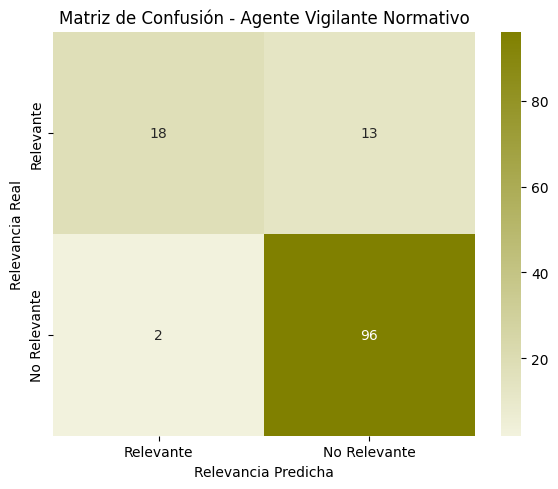

In [80]:
# Visualización Matriz de Confusión
plt.figure(figsize=(6, 5))
sns.heatmap(cm,
            annot=True,
            fmt="d",
             cmap=sns.light_palette("olive", reverse=False, as_cmap=True),
            xticklabels=[l.title() for l in labels],
            yticklabels=[l.title() for l in labels])
plt.xlabel("Relevancia Predicha")
plt.ylabel("Relevancia Real")
plt.title("Matriz de Confusión - Agente Vigilante Normativo")
plt.tight_layout()
plt.show()

In [81]:
# Mostrar métricas
print("Informe de Clasificación:\n")
print(classification_report(y_true, y_pred, target_names=[l.title() for l in labels]))

Informe de Clasificación:

              precision    recall  f1-score   support

   Relevante       0.88      0.98      0.93        98
No Relevante       0.90      0.58      0.71        31

    accuracy                           0.88       129
   macro avg       0.89      0.78      0.82       129
weighted avg       0.89      0.88      0.87       129



# Informe de Desempeño del Agente Vigilante Normativo - Etapa de Validación

## Evaluación General

Se evaluó el desempeño de un agente basado en recuperación aumentada con generación (RAG), utilizando LangChain, GPT-4o y Redis como base de conocimientos. El agente tiene como propósito identificar si nuevas normativas tributarias son Relevantes o No Relevantes para un sistema de cumplimiento normativo automatizado en Flow Pagos. La evaluación se realizó sobre un conjunto de 129 normativas nuevas (2025), etiquetadas previamente, pero no utilizadas durante el diseño del modelo.

## Métricas de Evaluación

| Métrica                  | Relevante | No Relevante |
|--------------------------|-----------|--------------|
| Precisión                | 0.88      | 0.90         |
| Recall                   | 0.98      | 0.58         |
| F1-Score                 | 0.93      | 0.71        |

- Accuracy general: 0.88  
- F1-score ponderado: 0.89  
- Total de normativas evaluadas: 129

## Análisis de Resultados

- El modelo presenta un **recall de 0.98 en la clase Relevante**, lo que significa que **detecta casi todas las normativas que podrían impactar la operación de la fintech**. Esto es especialmente importante, ya que omitir una normativa relevante podría tener consecuencias legales o tributarias.
  
- La **precisión en la clase Relevante es de 0.88**, lo que indica que la mayoría de las normativas clasificadas como relevantes efectivamente lo son. Desde el punto de vista operativo, esto reduce la carga de revisiones innecesarias por parte del equipo legal.

- En la clase No Relevante, el modelo tiene una **precisión de 0.90**, pero un **recall de 0.59**, lo que implica que algunas normativas irrelevantes están siendo clasificadas como relevantes. Aunque esto aumenta el número de revisiones manuales, no implica riesgos regulatorios.

- El **F1-score ponderado de 0.89 y accuracy de 0.89** reflejan un **nivel de rendimiento robusto**, que permite usar el agente como primer filtro con confianza, especialmente en escenarios donde el volumen normativo es alto.

## Recomendación

Se recomienda implementar el agente en un entorno productivo bajo un modelo asistido. El nivel de recall alcanzado en la detección de normativas relevantes garantiza que el sistema puede **reducir significativamente el riesgo de omisiones críticas**, mientras que las revisiones manuales sobre posibles falsos positivos permiten **mantener la precisión final del proceso de cumplimiento**.

Se sugiere además incorporar una capa de retroalimentación continua para capturar errores residuales y seguir afinando los criterios del modelo, con el fin de mejorar su desempeño en la clase No Relevante sin comprometer la cobertura de normativas clave.


In [ ]:
import pandas as pd

# Cargar archivo clasificado
df = pd.read_csv("data/normativas_nuevas_clasificadas.csv")

# Reglas simples de incoherencia
incoherencias = []

for i, row in df.iterrows():
    rel = str(row["relevancia"]).strip().lower()
    expl = str(row["explicacion"]).strip().lower()

    incoherente = False

    # Caso 1: Clasifica como RELEVANTE pero la explicación sugiere lo contrario
    if "no aporta" in expl or "no relevante" in expl or "fuera de alcance" in expl:
        if rel == "relevante":
            incoherente = True

    # Caso 2: Clasifica como NO RELEVANTE pero la explicación sugiere valor
    if "importante" in expl or "clave" in expl or "alineado" in expl:
        if rel == "no relevante":
            incoherente = True

    incoherencias.append(incoherente)

# Agregar resultado al DataFrame
df["explicacion_incoherente"] = incoherencias

# Estadísticas
total = len(df)
errores = sum(incoherencias)
coherentes = total - errores
porcentaje_error = errores / total * 100

print(f"🔍 Total normativas analizadas: {total}")
print(f"❌ Explicaciones incoherentes detectadas: {errores}")
print(f"✅ Explicaciones coherentes: {coherentes}")
print(f"📉 Porcentaje de incoherencia explicación ↔ relevancia: {porcentaje_error:.2f}%")

# Mostrar ejemplos de errores
print("\n🧾 Ejemplos de explicaciones incoherentes:")


🔍 Total normativas analizadas: 129
❌ Explicaciones incoherentes detectadas: 0
✅ Explicaciones coherentes: 129
📉 Porcentaje de incoherencia explicación ↔ relevancia: 0.00%

🧾 Ejemplos de explicaciones incoherentes:


In [ ]:
df[df["explicacion_incoherente"] == True][["name", "relevancia", "explicacion"]].head(10)

,name,relevancia,explicacion


In [ ]:
import pandas as pd

# Cargar ambos archivos
df_real = pd.read_csv("data/normativas_nuevas.csv")
df_pred = pd.read_csv("data/normativas_nuevas_clasificadas.csv")

# Renombrar columnas para diferenciarlas
df_real = df_real.rename(columns={"relevancia": "relevancia_real", "explicacion": "explicacion_real"})
df_pred = df_pred.rename(columns={"relevancia": "relevancia_predicha", "explicacion": "explicacion_predicha"})

# Unir por nombre (puedes cambiar por otro campo único si lo prefieres)
df_comparacion = pd.merge(df_real, df_pred, on="name", suffixes=("_real", "_predicha"))

# Filtrar falsos positivos: predijo 'Relevante' pero era 'No Relevante'
falsos_positivos = df_comparacion[
    (df_comparacion["relevancia_real"] == "No Relevante") &
    (df_comparacion["relevancia_predicha"] == "Relevante")
]

# Mostrar resumen general
print(f"Total de falsos positivos encontrados: {len(falsos_positivos)}")

# Opcional: exportar a Excel para revisión manual
falsos_positivos.to_excel("falsos_positivos_relevancia.xlsx", index=False)

# Ver patrones en las explicaciones del modelo (primeros 100 caracteres)
print("\nPatrones más comunes en explicaciones de falsos positivos:")
print(falsos_positivos["explicacion_predicha"].str[:100].value_counts().head(10))


Total de falsos positivos encontrados: 3

Patrones más comunes en explicaciones de falsos positivos:
explicacion_predicha
La normativa es relevante porque afecta directamente el cumplimiento tributario automatizado de la f    1
La normativa es relevante porque se refiere a la información de boletas de prestación de servicios d    1
La normativa es relevante porque se relaciona directamente con el cumplimiento tributario, específic    1
Name: count, dtype: int64


In [ ]:
falsos_positivos

,name,description_real,fuente_real,url_real,tipo_documento_real,cuerpo_real,relevancia_real,explicacion_real,description_predicha,fuente_predicha,url_predicha,tipo_documento_predicha,cuerpo_predicha,relevancia_predicha,explicacion_predicha
59,Resolución Exenta SII N° 14 del 30 de Enero de...,"Autoriza a empresa de correos de chile, Rut N°...",Fuente: Subdireccion De Fiscalizacion,https://www.sii.cl/normativa_legislacion/resol...,Resolución,considerando 1 que la empresa de correos de ch...,No Relevante,No cumple reglas de negocio,"Autoriza a empresa de correos de chile, Rut N°...",Fuente: Subdireccion De Fiscalizacion,https://www.sii.cl/normativa_legislacion/resol...,Resolución,considerando 1 que la empresa de correos de ch...,Relevante,La normativa es relevante porque afecta direct...
63,Resolución Exenta SII N° 18 del 13 de Febrero ...,Aprueba Adendum al Convenio de Intercambio de ...,Fuente: Subdireccion De Asistencia Al Contribu...,https://www.sii.cl/normativa_legislacion/resol...,Resolución,considerando 1 que corresponde al servicio de ...,No Relevante,No cumple reglas de negocio,Aprueba Adendum al Convenio de Intercambio de ...,Fuente: Subdireccion De Asistencia Al Contribu...,https://www.sii.cl/normativa_legislacion/resol...,Resolución,considerando 1 que corresponde al servicio de ...,Relevante,La normativa es relevante porque se refiere a ...
108,Resolución Exenta SII N° 63 del 22 de Mayo del...,"Autoriza a Banco Santander Chile, Rut n° 97.03...",Fuente: Subdireccion De Fiscalizacion,https://www.sii.cl/normativa_legislacion/resol...,Resolución,considerando 1 que el contribuyente banco sant...,No Relevante,No cumple reglas de negocio,"Autoriza a Banco Santander Chile, Rut n° 97.03...",Fuente: Subdireccion De Fiscalizacion,https://www.sii.cl/normativa_legislacion/resol...,Resolución,considerando 1 que el contribuyente banco sant...,Relevante,La normativa es relevante porque se relaciona ...
